[]
0


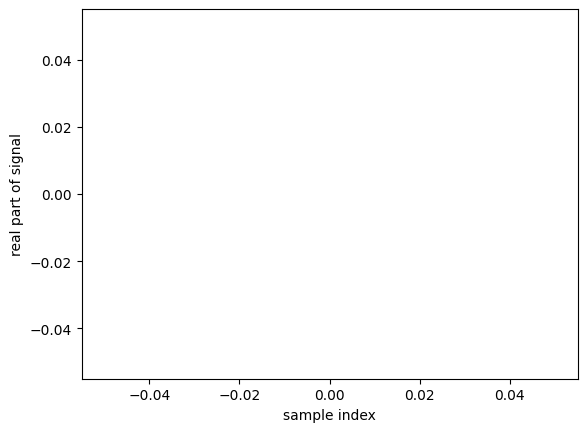

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import file_read

# CSE910 HW3
Jeremy Arsenault
***********************

### HW 2 Stuff:

In [2]:
# bit generation
def generate_bits(n):
    return np.random.randint(0,2,n)

# modulation / demodulation
def get_mod_map(mod_order):
    n = int(np.sqrt(mod_order))
    m = []
    for i in range(mod_order):
        m.append([ (i//n - (n-1)/2) + 1j*(i%n - (n-1)/2)])
    m = np.array(m)
    m /= np.linalg.norm(m, axis=-1).mean() # scale power
    return m.flatten()

def bits_to_complex(bits, mod_order):
    b = int(np.log2(mod_order))
    bits = bits.reshape((-1, b))
    inds = (bits * np.power(2, np.arange(b))).sum(axis=-1).astype(int)
    return get_mod_map(mod_order)[inds]
    
def complex_to_bits(nums, mod_order):
    b = int(np.log2(mod_order))
    dists = np.absolute(np.repeat(nums, mod_order).reshape((-1, mod_order)) - get_mod_map(mod_order))
    inds = np.argmin(dists, axis=-1)
    pows = np.power(2, np.arange(b))
    inds = np.tile(inds.reshape(-1,1), (b))
    return ((inds // pows) % 2).flatten()

# fft/ifft and cp handling / symbol alignment
# note: using correlative symbol alignment in symbol_to_nums
def nums_to_symbol(nums, cp_len):
    s = np.fft.ifft(nums)
    return np.hstack([s[-cp_len:],s])

def symbol_to_nums(symbol, cp_len):
    # fft and rescaling
    return np.fft.fft(symbol[cp_len:])

# simulate channel
def channel(frame, snr, tap_delays, tap_coef):
    l = len(frame)+max(tap_delays)
    f = (np.random.randn(l) +1j*np.random.randn(l) )/(10**(snr/10)) # took forever to realize I was missing dB conversion >:(
    # for t,c in zip(tap_delays, tap_coef): # equivalent to np.convolve
    #     f[t:t+len(frame)] += c * frame
    x = np.zeros(max(tap_delays)+1, dtype=complex)
    for t,c in zip(tap_delays, tap_coef):
        x[t] = c
    f += np.convolve(frame, x)
    return f

### Frame Structure and Time Synchronization:

In [209]:
def get_sc_inds():
    '''get unused, payload, and pilot subcarrier indices'''
    null_padding = 5
    null_sc = np.hstack([np.arange(null_padding), np.arange(null_padding)+64-null_padding])
    payload_sc = 32 + np.array(file_read.payload_sc)
    pilot_sc = np.array([i for i in range(64) if (0<np.absolute(np.hstack([null_sc,payload_sc])-i).min())])
    return null_sc, payload_sc, pilot_sc

def get_pilot(sc):
    '''use provided freq_pilot array to retrieve frequencies for pilot indices'''
    p = np.array(file_read.freq_pilot)[sc]
    return p[:,0] + 1j*p[:,1]

def gen_piloted_nums():
    '''generate a random payload, then add pilot and turn into freqs'''
    null_sc, payload_sc, pilot_sc = get_sc_inds()
    
    symbol = np.zeros(64, dtype=complex)
    payload = bits_to_complex(np.random.randint(0,2,(len(payload_sc),2)), 4)
    pilot = get_pilot(pilot_sc)
    
    symbol[payload_sc] += payload
    symbol[pilot_sc] += pilot
    return symbol

def gen80211n_legacy_frame(symbols, mod_ord=4):
    '''
    "(i) L-STF (the legacy short 
    training field with 10 repetitions of a short symbol with period of 16 
    samples, P=16); (ii) L-LTF (the legacy long training field with 2 
    repetitions of a long symbol with 64 samples each, P=64, plus a CP 
    with 32 samples); (iii) L-SIG (the legacy signal field with 24 control 
    bits encoded with a BCC with r=½  and modulated using binary 
    phase-shift keying, BPSK)"
    
    https://www.researchgate.net/publication/261382561_On_the_synchronization_of_IEEE_80211N_devices_over_frequency_selective_TGN_channel_models
    '''
    preamble_f = np.array(file_read.freq_preamble)
    preamble_f = preamble_f[:,:,0]+1j*preamble_f[:,:,1]
    preamble = [nums_to_symbol(x,16) for x in preamble_f]
    
    frame = preamble + symbols + [np.zeros(100)]
    return np.hstack(frame)

# 
def corr_alignment(frame, max_delay=50, debug=False):
    '''
    use short preamble to get alignment mod 16
    use long preamble to get alignment // 16
    '''
    # helper
    def autocorr(seq, s, l, n):
        corr = 0
        for i in range(n-1):
            for j in range(i+1,n):
                x1, x2 = seq[s+i*l:s+(i+1)*l], seq[s+j*l:s+(j+1)*l]
                x1, x2 = x1 / np.absolute(x1).max(), x2 / np.absolute(x2).max()
                c = (x1 * x2.conj()).mean().real
                corr += 2*c/(n*(n-1))
        return corr
    
    # short alignment
    s_corrs = [autocorr(frame, i, 16, 10) for i  in range(max_delay)]
    sa = np.argmax(s_corrs)
    # long alignment
    l_corrs = [autocorr(frame, 160+sa+i, 64, 2) for i in range(0,max_delay+32,16)]
    la = np.argmax(l_corrs)
    a = sa + 16*la
    if debug:
        return a, s_corrs
    else:
        return frame[a:]


rel_delay = np.array([0, 7])
tap = [1+.01j, 0.02+0.01j]
snr = 30
max_delay = 50

acc = 0
n = 100
for _ in range(n):
    delay = np.random.randint(1,max_delay)
    a = gen80211n_legacy_frame([nums_to_symbol(gen_piloted_nums(), 16)])
    b = channel(a, snr, delay+rel_delay, tap)
    c, sc = corr_alignment(b, debug=True)
    acc += float(delay==c)/n

print(f"SNR: {snr}  Time Sync Accuracy: {acc:.4f}   (n={n})")

SNR: 30  Time Sync Accuracy: 0.8700   (n=100)


### Phase Correction and Channel Estimation:

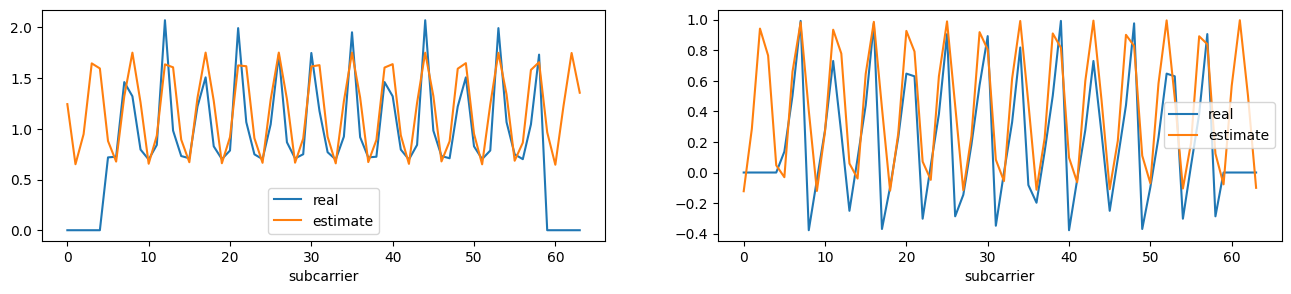

In [354]:
def channel_estimate(symbol):
    '''
    use pilot channels as refrence to estimate channel.
    observation: channel appears to be well appriximated by the family of functions { (a+b*e^-i(f*t+ph) }
                also, 'amplidute' and 'waveform' components are independent.
    approach: create set of steering vectors parameterized by f and correlate with normed signal. Choose
                f with highest |corr| and phase offset ph as respective corr direction.
    '''
    null_sc, payload_sc, pilot_sc = get_sc_inds()
    ref_pilot = get_pilot(pilot_sc)
    rec_pilot = symbol[pilot_sc]
    
    h = ref_pilot / rec_pilot
    h, m = h - h.mean(), h.mean()
    h, s = h / np.absolute(h).mean(), np.absolute(h).mean()
    
    thetas = 2*np.pi*np.linspace(1/len(symbol),1,1000)
    corrs, phs = [], []
    for th in thetas:
        corr = (h.conj()*np.exp(1j*th*pilot_sc)).mean()
        corrs.append(np.absolute(corr))
        phs.append(np.angle(corr))
    i = np.argmax(corrs)
    H = (corrs[i])*np.exp(1j*thetas[i]*np.arange(len(symbol))-1j*phs[i])
    return H*s + m
    
def equalize(symbol, h):
    return symbol * h

def recover_payload(symbol):
    null_sc, payload_sc, pilot_sc = get_sc_inds()
    return symbol[payload_sc]

# simulation parameters
delays = np.array([15, 29])
taps = [0.9-0.2j, 0.4 +0.2j]
snr = 60

# do simulation
s = gen_piloted_nums()
fr = gen80211n_legacy_frame([nums_to_symbol(s, 16)])
ch = channel(fr, snr, delays, taps)
s0 = symbol_to_nums(ch[min(delays)+80*4:min(delays)+80*5], 16)
H0 = s / s0
H = channel_estimate(s0)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,3))

ax1.plot(H0.real, label='real')
ax1.plot(H.real, label='estimate')
ax1.set_xlabel("subcarrier")
ax1.legend()

ax2.plot(H0.imag, label='real')
ax2.plot(H.imag, label='estimate')
ax2.set_xlabel("subcarrier")
ax2.legend()

plt.show()

### Simulate:

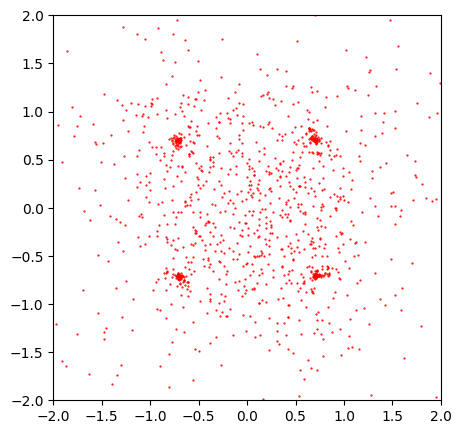

In [369]:
payloads = []
n = 30

# b = 300
for _ in range(n):
    # randomise simulation parameters
    paths = 1+np.random.randint(3)
    delays = np.sort(np.random.randint(1,32,paths))
    taps = np.exp(1j*np.random.randn(paths)) * min(delays**2)/(delays**2)
    snr = 25 + 20*np.random.rand()
    
    # do simulation
    s = gen_piloted_nums()
    fr = gen80211n_legacy_frame([nums_to_symbol(s, 16)])
    ch = channel(fr, snr, delays, taps)
    s0 = symbol_to_nums(corr_alignment(ch)[80*4:80*5], 16)
    H = channel_estimate(s0)
    p = recover_payload(equalize(s0,H))

    payloads.append(p)
payloads = np.hstack(payloads)

fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(payloads.real, payloads.imag, color='red', s=0.3)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])

plt.show()